<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/4_multi_dimensional_steering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Multi-Dimensional Steering

This notebook extends the contrastive steering approach to **multiple demographic dimensions**:

1. **Party:** Republican vs Democrat
2. **Race:** White vs Black
3. **Education:** College vs No College

## Research Questions

1. Do different demographic dimensions capture independent variation?
2. Can we simulate specific demographic profiles (e.g., "college-educated Black Democrat")?
3. How do multi-dimensional steered responses compare to GSS subgroup data?

## Approach

Multi-dimensional steering vector:
```
v_multi = α(v_Rep - v_Dem) + β(v_White - v_Black) + γ(v_College - v_NoCollege)
```

Where α, β, γ are steering strengths for each dimension.

## 1. Setup & Imports

In [5]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
os.makedirs(BASE_DIR, exist_ok=True)
print(f"Base directory: {BASE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base directory: /content/drive/MyDrive/belief_and_llms_v0


In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch.nn.functional as F

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


## 2. Load Model

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Install/Upgrade bitsandbytes
!pip install -U bitsandbytes>=0.46.1

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")
print(f"Number of layers: {len(model.model.layers)}")

Loading model...


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded: meta-llama/Meta-Llama-3-8B-Instruct
Number of layers: 32


## 3. Load Demographic Vectors

In [7]:
# Load vectors from the best layer (Layer 8 from previous analysis)
STEERING_LAYER = 8

vectors_path = os.path.join(BASE_DIR, f"vectors/gss_demographic_vectors_layer{STEERING_LAYER}.pt")
vectors_data = torch.load(vectors_path)

print(f"Loaded vectors from layer {STEERING_LAYER}")
# Corrected line: 'vectors_data' directly contains the demographic keys
print(f"Available demographics: {len(vectors_data)}")

# List all available demographic keys
# Corrected line: 'vectors_data' directly contains the demographic keys
for key in sorted(vectors_data.keys()):
    print(f"  - {key}")

Loaded vectors from layer 8
Available demographics: 34
  - Degree_high school graduate
  - Degree_person with a bachelor's degree
  - Degree_person with a graduate degree
  - Degree_person with less than high school education
  - Degree_person with some college education
  - Generation_Baby Boomer
  - Generation_Millennial
  - Generation_person from Generation X
  - Generation_person from Generation Z
  - Generation_person from the Silent Generation
  - PartyID_Democrat
  - PartyID_Independent leaning Democrat
  - PartyID_Independent leaning Republican
  - PartyID_Other
  - PartyID_Political Independent
  - PartyID_Republican
  - PartyID_Strong Democrat
  - PartyID_Strong Republican
  - PolViews_person with a conservative political view
  - PolViews_person with a liberal political view
  - PolViews_person with a neutral political view
  - PolViews_person with a slightly conservative political view
  - PolViews_person with a slightly liberal political view
  - PolViews_person with an ex

## 4. Create Multi-Dimensional Contrastive Vectors

In [10]:
# Define the contrastive pairs for each dimension
# Note: Adjust these keys based on actual vector names in your data

CONTRASTIVE_DIMENSIONS = {
    "party": {
        "positive": "PartyID_Strong Republican",  # Positive direction
        "negative": "PartyID_Strong Democrat",    # Negative direction
        "label": "Republican ↔ Democrat"
    },
    "race": {
        "positive": "Race_White person",
        "negative": "Race_Black person",
        "label": "White ↔ Black"
    },
    "education": {
        "positive": "Degree_person with a graduate degree",  # or college degree
        "negative": "Degree_high school graduate", # Corrected key
        "label": "College ↔ No College"
    }
}

# Create contrastive vectors for each dimension
contrastive_vectors = {}

for dim_name, dim_config in CONTRASTIVE_DIMENSIONS.items():
    pos_key = dim_config["positive"]
    neg_key = dim_config["negative"]

    if pos_key in vectors_data and neg_key in vectors_data:
        pos_vec = vectors_data[pos_key]['vector']
        neg_vec = vectors_data[neg_key]['vector']
        contrastive_vec = pos_vec - neg_vec

        contrastive_vectors[dim_name] = {
            "vector": contrastive_vec,
            "label": dim_config["label"],
            "positive": pos_key,
            "negative": neg_key
        }
        print(f"{dim_name}: {dim_config['label']}")
        print(f"  Vector norm: {contrastive_vec.norm().item():.4f}")
    else:
        print(f"WARNING: Could not find vectors for {dim_name}")
        print(f"  Missing: {pos_key if pos_key not in vectors_data else neg_key}")

party: Republican ↔ Democrat
  Vector norm: 0.4897
race: White ↔ Black
  Vector norm: 0.6157
education: College ↔ No College
  Vector norm: 0.7676


=== Correlation Between Contrastive Dimensions ===
(Low correlation = independent dimensions)



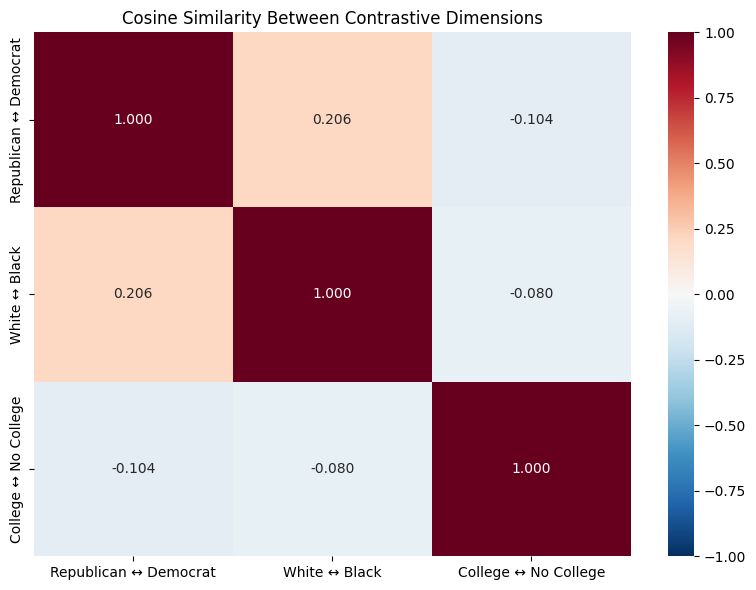

party ↔ race: 0.206
party ↔ education: -0.104
race ↔ education: -0.080


In [11]:
# Check correlation between contrastive dimensions
# If highly correlated, they capture similar variation

print("=== Correlation Between Contrastive Dimensions ===")
print("(Low correlation = independent dimensions)\n")

dim_names = list(contrastive_vectors.keys())
correlation_matrix = np.zeros((len(dim_names), len(dim_names)))

for i, dim1 in enumerate(dim_names):
    for j, dim2 in enumerate(dim_names):
        v1 = contrastive_vectors[dim1]["vector"]
        v2 = contrastive_vectors[dim2]["vector"]

        # Cosine similarity
        cos_sim = F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
        correlation_matrix[i, j] = cos_sim

# Display as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f",
            xticklabels=[contrastive_vectors[d]["label"] for d in dim_names],
            yticklabels=[contrastive_vectors[d]["label"] for d in dim_names],
            cmap="RdBu_r", center=0, vmin=-1, vmax=1)
plt.title("Cosine Similarity Between Contrastive Dimensions")
plt.tight_layout()
plt.show()

# Print correlation values
for i, dim1 in enumerate(dim_names):
    for j, dim2 in enumerate(dim_names):
        if i < j:
            print(f"{dim1} ↔ {dim2}: {correlation_matrix[i,j]:.3f}")

## 5. Define Multi-Dimensional Steering Function

In [12]:
def get_multi_dim_steering_vector(dimension_strengths):
    """
    Create a combined steering vector from multiple dimensions.

    Args:
        dimension_strengths: dict mapping dimension name to strength
            e.g., {"party": 2.0, "race": 1.0, "education": -1.0}

    Returns:
        Combined steering vector
    """
    combined_vector = None

    for dim_name, strength in dimension_strengths.items():
        if dim_name in contrastive_vectors:
            vec = contrastive_vectors[dim_name]["vector"] * strength
            if combined_vector is None:
                combined_vector = vec
            else:
                combined_vector = combined_vector + vec

    return combined_vector


def get_binary_choice_prob_multi(prompt, dimension_strengths, layer_idx):
    """
    Get probability of choosing option A vs B with multi-dimensional steering.

    Args:
        prompt: Binary choice prompt
        dimension_strengths: dict mapping dimension name to strength
        layer_idx: Layer to inject at

    Returns:
        Probability of option A
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Get combined steering vector
    steering_vector = get_multi_dim_steering_vector(dimension_strengths)

    if steering_vector is None:
        # No steering, just run model
        with torch.no_grad():
            outputs = model(**inputs)
    else:
        steer_vec = steering_vector.to(model.device).to(model.dtype)

        def steering_hook(module, input, output):
            perturbation = steer_vec.view(1, 1, -1)
            if isinstance(output, tuple):
                modified_hidden = output[0] + perturbation
                return (modified_hidden,) + output[1:]
            elif isinstance(output, torch.Tensor):
                return output + perturbation
            return output

        layer = model.model.layers[layer_idx]
        handle = layer.register_forward_hook(steering_hook)

        try:
            with torch.no_grad():
                outputs = model(**inputs)
        finally:
            handle.remove()

    # Get logits for next token
    next_token_logits = outputs.logits[0, -1, :]

    # Get token IDs for A and B
    id_a = tokenizer.encode(" A", add_special_tokens=False)[-1]
    id_b = tokenizer.encode(" B", add_special_tokens=False)[-1]

    # Compute probabilities
    probs = F.softmax(torch.tensor([next_token_logits[id_a], next_token_logits[id_b]]), dim=0)

    return probs[0].item()

print("Multi-dimensional steering functions defined.")

Multi-dimensional steering functions defined.


## 6. Define Policy Questions & GSS Mappings

In [13]:
# Policy questions (same as before)
POLICY_QUESTIONS = {
    "abortion": {
        "binary_prompt": "[INST] What is your stance on abortion? [/INST]\n(A) Pro-choice (woman should have the right to choose)\n(B) Pro-life (abortion should be restricted or banned)\nAnswer:",
        "option_a_label": "Pro-choice",
        "option_b_label": "Pro-life",
        "gss_variable": "ABANY"
    },
    "death_penalty": {
        "binary_prompt": "[INST] What is your stance on the death penalty for persons convicted of murder? [/INST]\n(A) Oppose the death penalty\n(B) Favor the death penalty\nAnswer:",
        "option_a_label": "Oppose",
        "option_b_label": "Favor",
        "gss_variable": "CAPPUN"
    },
    "gun_control": {
        "binary_prompt": "[INST] What is your stance on gun control? [/INST]\n(A) Support stricter gun control laws\n(B) Protect Second Amendment gun rights\nAnswer:",
        "option_a_label": "Stricter control",
        "option_b_label": "Protect 2A",
        "gss_variable": "GUNLAW"
    }
}

print(f"Defined {len(POLICY_QUESTIONS)} policy questions.")

Defined 3 policy questions.


## 7. Load GSS Data for Subgroup Analysis

In [14]:
# Load GSS data
gss_path = os.path.join(BASE_DIR, "data/gss_cleaned.csv")
gss_df = pd.read_csv(gss_path)

print(f"Loaded GSS data: {len(gss_df)} rows")
print(f"Columns: {list(gss_df.columns)}")
print(f"\nYear range: {gss_df['year'].min()} - {gss_df['year'].max()}")

Loaded GSS data: 20974 rows
Columns: ['year', 'partyid', 'PARTYID', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews', 'ABANY', 'CAPPUN', 'GUNLAW', 'MARSAME1']

Year range: 2006 - 2024


In [15]:
# Create binary variables for multi-dimensional filtering

# Party: Democrat (0,1,2) vs Republican (4,5,6)
gss_df['party_binary'] = gss_df['PARTYID'].apply(
    lambda x: 'Democrat' if x in [0, 1, 2] else ('Republican' if x in [4, 5, 6] else 'Independent')
)

# Race: White vs Black (from 'race' column)
# Note: Check actual values in your data
print("Race values:", gss_df['race'].unique())

# Education: College vs No College (from 'degree' column)
print("Degree values:", gss_df['degree'].unique())

Race values: ['Other' 'White' 'Black']
Degree values: ['High school' 'Less than high school' "Bachelor's"
 'Associate/junior college' 'Graduate']


In [16]:
# Create education binary
# Adjust based on actual values in your data
college_degrees = ['Bachelor', 'Graduate']  # Adjust these
gss_df['education_binary'] = gss_df['degree'].apply(
    lambda x: 'College' if x in college_degrees else 'No College'
)

# Create race binary (White vs Black only for this analysis)
gss_df['race_binary'] = gss_df['race'].apply(
    lambda x: x if x in ['White', 'Black'] else 'Other'
)

print("Party distribution:")
print(gss_df['party_binary'].value_counts())
print("\nEducation distribution:")
print(gss_df['education_binary'].value_counts())
print("\nRace distribution:")
print(gss_df['race_binary'].value_counts())

Party distribution:
party_binary
Democrat       9085
Republican     7922
Independent    3967
Name: count, dtype: int64

Education distribution:
education_binary
No College    18454
College        2520
Name: count, dtype: int64

Race distribution:
race_binary
White    15549
Black     3239
Other     2186
Name: count, dtype: int64


In [17]:
def compute_gss_subgroup_prob(gss_df, topic, party=None, race=None, education=None):
    """
    Compute GSS probability for a demographic subgroup.

    Args:
        gss_df: GSS dataframe
        topic: Policy topic
        party: 'Democrat', 'Republican', or None
        race: 'White', 'Black', or None
        education: 'College', 'No College', or None

    Returns:
        Probability of Option A, sample size
    """
    config = POLICY_QUESTIONS[topic]
    var = config["gss_variable"]

    if var not in gss_df.columns:
        return None, 0

    # Filter by demographics
    filtered_df = gss_df.copy()

    if party:
        filtered_df = filtered_df[filtered_df['party_binary'] == party]
    if race:
        filtered_df = filtered_df[filtered_df['race_binary'] == race]
    if education:
        filtered_df = filtered_df[filtered_df['education_binary'] == education]

    # Define option A values based on topic
    if topic == "abortion":
        option_a_values = [1]  # YES
        option_b_values = [2]  # NO
    elif topic == "death_penalty":
        option_a_values = [2]  # OPPOSE
        option_b_values = [1]  # FAVOR
    elif topic == "gun_control":
        option_a_values = [1]  # FAVOR
        option_b_values = [2]  # OPPOSE
    else:
        return None, 0

    valid_values = option_a_values + option_b_values
    valid_df = filtered_df[filtered_df[var].isin(valid_values)]

    if len(valid_df) == 0:
        return None, 0

    option_a_count = valid_df[var].isin(option_a_values).sum()
    prob_a = option_a_count / len(valid_df)

    return prob_a, len(valid_df)

print("GSS subgroup function defined.")

GSS subgroup function defined.


## 8. Test Single Dimension Effects

In [18]:
# First, test each dimension independently
print("=== SINGLE DIMENSION STEERING EFFECTS ===")
print(f"Layer: {STEERING_LAYER}\n")

single_dim_results = []

for topic in POLICY_QUESTIONS.keys():
    prompt = POLICY_QUESTIONS[topic]["binary_prompt"]
    print(f"\n{topic.upper()}:")

    # Baseline (no steering)
    baseline_prob = get_binary_choice_prob_multi(prompt, {}, STEERING_LAYER)
    print(f"  Baseline: P(A) = {baseline_prob:.1%}")

    for dim_name in contrastive_vectors.keys():
        # Test positive and negative steering
        for strength in [-2.0, 2.0]:
            prob = get_binary_choice_prob_multi(prompt, {dim_name: strength}, STEERING_LAYER)
            direction = "positive" if strength > 0 else "negative"

            single_dim_results.append({
                "topic": topic,
                "dimension": dim_name,
                "strength": strength,
                "prob_a": prob,
                "delta": prob - baseline_prob
            })

            print(f"  {dim_name} ({strength:+.1f}): P(A) = {prob:.1%} (Δ = {prob - baseline_prob:+.1%})")

single_dim_df = pd.DataFrame(single_dim_results)
print("\nDone!")

=== SINGLE DIMENSION STEERING EFFECTS ===
Layer: 8


ABORTION:
  Baseline: P(A) = 75.4%
  party (-2.0): P(A) = 87.9% (Δ = +12.5%)
  party (+2.0): P(A) = 56.2% (Δ = -19.1%)
  race (-2.0): P(A) = 77.7% (Δ = +2.3%)
  race (+2.0): P(A) = 80.9% (Δ = +5.5%)
  education (-2.0): P(A) = 63.7% (Δ = -11.7%)
  education (+2.0): P(A) = 85.2% (Δ = +9.8%)

DEATH_PENALTY:
  Baseline: P(A) = 46.9%
  party (-2.0): P(A) = 74.2% (Δ = +27.3%)
  party (+2.0): P(A) = 20.2% (Δ = -26.7%)
  race (-2.0): P(A) = 62.1% (Δ = +15.2%)
  race (+2.0): P(A) = 35.0% (Δ = -11.9%)
  education (-2.0): P(A) = 43.8% (Δ = -3.1%)
  education (+2.0): P(A) = 56.2% (Δ = +9.4%)

GUN_CONTROL:
  Baseline: P(A) = 57.8%
  party (-2.0): P(A) = 92.6% (Δ = +34.8%)
  party (+2.0): P(A) = 14.8% (Δ = -43.0%)
  race (-2.0): P(A) = 46.9% (Δ = -10.9%)
  race (+2.0): P(A) = 76.6% (Δ = +18.8%)
  education (-2.0): P(A) = 51.6% (Δ = -6.2%)
  education (+2.0): P(A) = 65.2% (Δ = +7.4%)

Done!


## 9. Test Multi-Dimensional Combinations

In [19]:
# Define demographic profiles to simulate
# Positive strength = toward White/Republican/College
# Negative strength = toward Black/Democrat/NoCollege

DEMOGRAPHIC_PROFILES = {
    "White Republican College": {"party": 2.0, "race": 2.0, "education": 2.0},
    "White Republican No-College": {"party": 2.0, "race": 2.0, "education": -2.0},
    "White Democrat College": {"party": -2.0, "race": 2.0, "education": 2.0},
    "White Democrat No-College": {"party": -2.0, "race": 2.0, "education": -2.0},
    "Black Republican College": {"party": 2.0, "race": -2.0, "education": 2.0},
    "Black Republican No-College": {"party": 2.0, "race": -2.0, "education": -2.0},
    "Black Democrat College": {"party": -2.0, "race": -2.0, "education": 2.0},
    "Black Democrat No-College": {"party": -2.0, "race": -2.0, "education": -2.0},
}

print(f"Defined {len(DEMOGRAPHIC_PROFILES)} demographic profiles to test.")

Defined 8 demographic profiles to test.


In [20]:
# Test all demographic profiles
print("=== MULTI-DIMENSIONAL STEERING RESULTS ===")
print(f"Layer: {STEERING_LAYER}\n")

multi_dim_results = []

for topic in POLICY_QUESTIONS.keys():
    prompt = POLICY_QUESTIONS[topic]["binary_prompt"]
    print(f"\n{topic.upper()}:")

    for profile_name, strengths in DEMOGRAPHIC_PROFILES.items():
        prob = get_binary_choice_prob_multi(prompt, strengths, STEERING_LAYER)

        multi_dim_results.append({
            "topic": topic,
            "profile": profile_name,
            "party_strength": strengths.get("party", 0),
            "race_strength": strengths.get("race", 0),
            "education_strength": strengths.get("education", 0),
            "llm_prob_a": prob
        })

        print(f"  {profile_name}: P(A) = {prob:.1%}")

multi_dim_df = pd.DataFrame(multi_dim_results)
print("\nDone!")

=== MULTI-DIMENSIONAL STEERING RESULTS ===
Layer: 8


ABORTION:
  White Republican College: P(A) = 81.6%
  White Republican No-College: P(A) = 59.4%
  White Democrat College: P(A) = 93.8%
  White Democrat No-College: P(A) = 87.9%
  Black Republican College: P(A) = 68.0%
  Black Republican No-College: P(A) = 43.8%
  Black Democrat College: P(A) = 93.0%
  Black Democrat No-College: P(A) = 85.2%

DEATH_PENALTY:
  White Republican College: P(A) = 10.7%
  White Republican No-College: P(A) = 10.1%
  White Democrat College: P(A) = 79.7%
  White Democrat No-College: P(A) = 66.4%
  Black Republican College: P(A) = 40.8%
  Black Republican No-College: P(A) = 37.7%
  Black Democrat College: P(A) = 93.0%
  Black Democrat No-College: P(A) = 78.9%

GUN_CONTROL:
  White Republican College: P(A) = 32.0%
  White Republican No-College: P(A) = 29.5%
  White Democrat College: P(A) = 93.8%
  White Democrat No-College: P(A) = 91.4%
  Black Republican College: P(A) = 24.5%
  Black Republican No-College: P(A)

## 10. Compare with GSS Subgroups

In [21]:
# Compute GSS probabilities for matching subgroups
print("=== GSS SUBGROUP PROBABILITIES ===")

gss_subgroup_results = []

for topic in POLICY_QUESTIONS.keys():
    print(f"\n{topic.upper()}:")

    for party in ['Democrat', 'Republican']:
        for race in ['White', 'Black']:
            for education in ['College', 'No College']:
                prob, n = compute_gss_subgroup_prob(
                    gss_df, topic,
                    party=party, race=race, education=education
                )

                profile_name = f"{race} {party} {education.replace(' ', '-')}"

                gss_subgroup_results.append({
                    "topic": topic,
                    "profile": profile_name,
                    "party": party,
                    "race": race,
                    "education": education,
                    "gss_prob_a": prob,
                    "gss_n": n
                })

                if prob is not None:
                    print(f"  {profile_name}: P(A) = {prob:.1%} (n={n})")
                else:
                    print(f"  {profile_name}: No data")

gss_subgroup_df = pd.DataFrame(gss_subgroup_results)
print("\nDone!")

=== GSS SUBGROUP PROBABILITIES ===

ABORTION:
  White Democrat College: P(A) = 81.7% (n=509)
  White Democrat No-College: P(A) = 53.4% (n=2466)
  Black Democrat College: P(A) = 69.1% (n=110)
  Black Democrat No-College: P(A) = 47.2% (n=1246)
  White Republican College: P(A) = 32.3% (n=433)
  White Republican No-College: P(A) = 28.6% (n=3446)
  Black Republican College: P(A) = 12.5% (n=8)
  Black Republican No-College: P(A) = 41.3% (n=138)

DEATH_PENALTY:
  White Democrat College: P(A) = 66.7% (n=841)
  White Democrat No-College: P(A) = 40.5% (n=4034)
  Black Democrat College: P(A) = 63.4% (n=191)
  Black Democrat No-College: P(A) = 56.4% (n=1937)
  White Republican College: P(A) = 23.3% (n=692)
  White Republican No-College: P(A) = 18.3% (n=5587)
  Black Republican College: P(A) = 53.8% (n=13)
  Black Republican No-College: P(A) = 42.9% (n=212)

GUN_CONTROL:
  White Democrat College: P(A) = 91.3% (n=667)
  White Democrat No-College: P(A) = 82.7% (n=3001)
  Black Democrat College: P(A) 

In [22]:
# Merge LLM and GSS results for comparison
comparison_df = multi_dim_df.merge(
    gss_subgroup_df[["topic", "profile", "gss_prob_a", "gss_n"]],
    on=["topic", "profile"],
    how="left"
)

# Calculate error
comparison_df["error"] = abs(comparison_df["llm_prob_a"] - comparison_df["gss_prob_a"])

print("=== LLM vs GSS COMPARISON ===")
print(comparison_df.to_string(index=False))

print(f"\nMean absolute error: {comparison_df['error'].mean():.3f}")

=== LLM vs GSS COMPARISON ===
        topic                     profile  party_strength  race_strength  education_strength  llm_prob_a  gss_prob_a  gss_n    error
     abortion    White Republican College             2.0            2.0                 2.0    0.816406    0.323326    433 0.493081
     abortion White Republican No-College             2.0            2.0                -2.0    0.593750    0.286129   3446 0.307621
     abortion      White Democrat College            -2.0            2.0                 2.0    0.937500    0.817289    509 0.120211
     abortion   White Democrat No-College            -2.0            2.0                -2.0    0.878906    0.534469   2466 0.344437
     abortion    Black Republican College             2.0           -2.0                 2.0    0.679688    0.125000      8 0.554688
     abortion Black Republican No-College             2.0           -2.0                -2.0    0.437500    0.413043    138 0.024457
     abortion      Black Democrat Colle

## 11. Visualization

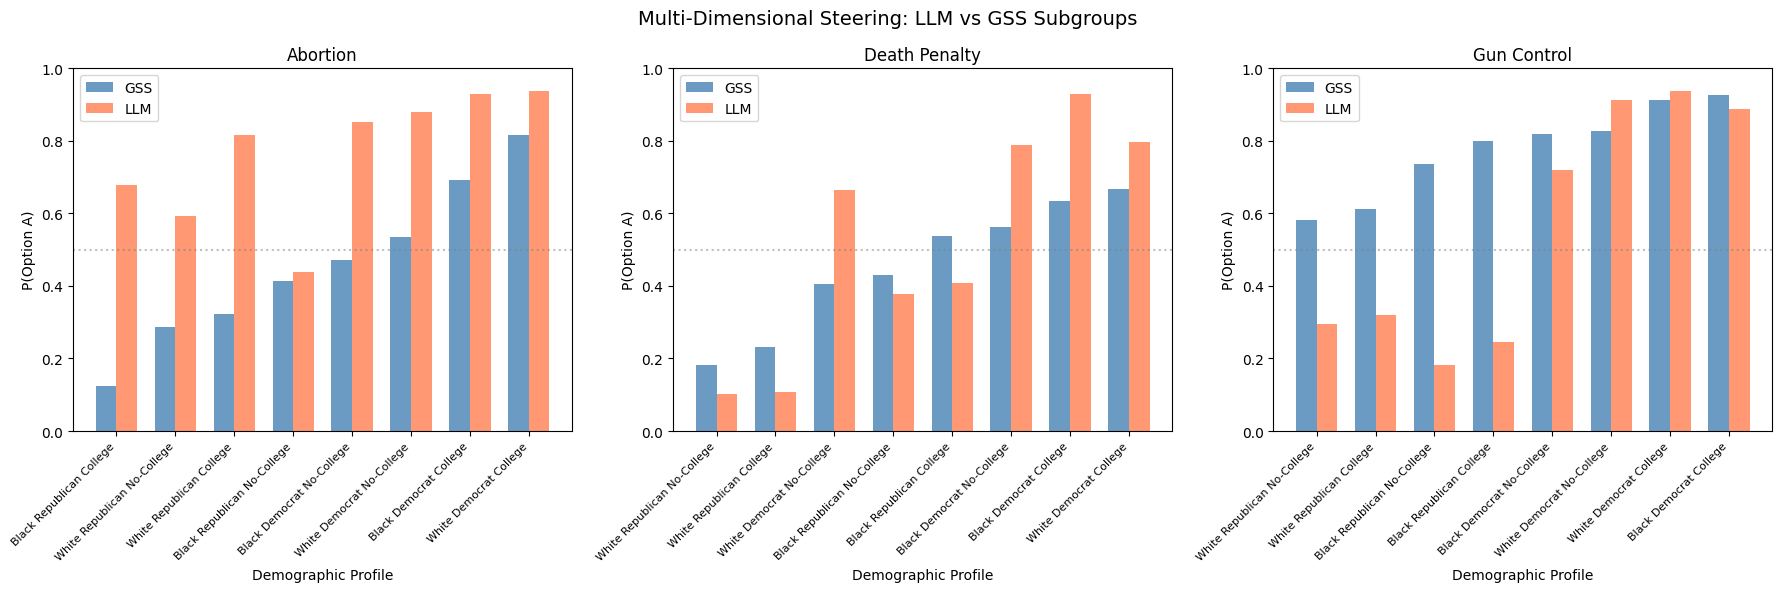

In [23]:
# Visualize LLM vs GSS for each topic
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, topic in enumerate(POLICY_QUESTIONS.keys()):
    ax = axes[idx]
    topic_df = comparison_df[comparison_df["topic"] == topic].copy()

    # Sort by GSS probability for better visualization
    topic_df = topic_df.sort_values("gss_prob_a")

    x = range(len(topic_df))
    width = 0.35

    bars1 = ax.bar([i - width/2 for i in x], topic_df["gss_prob_a"], width,
                   label="GSS", color="steelblue", alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], topic_df["llm_prob_a"], width,
                   label="LLM", color="coral", alpha=0.8)

    ax.set_xlabel("Demographic Profile")
    ax.set_ylabel("P(Option A)")
    ax.set_title(f"{topic.replace('_', ' ').title()}")
    ax.set_xticks(x)
    ax.set_xticklabels(topic_df["profile"], rotation=45, ha="right", fontsize=8)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

plt.suptitle("Multi-Dimensional Steering: LLM vs GSS Subgroups", fontsize=14)
plt.tight_layout()
plt.show()

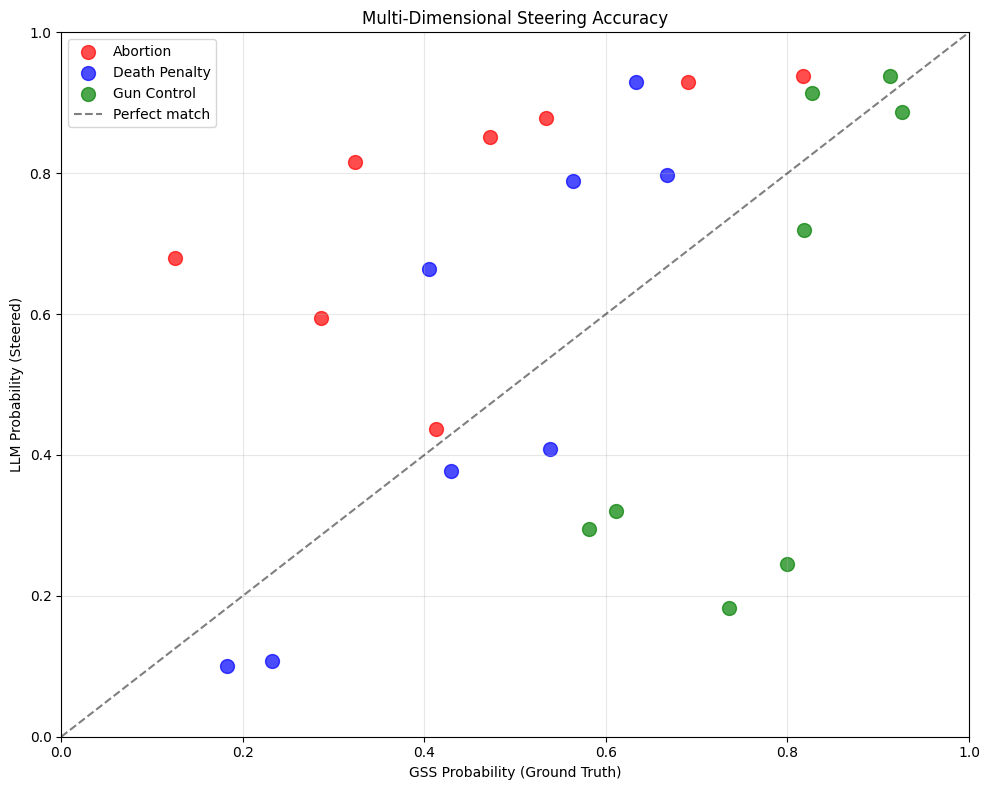

Correlation between LLM and GSS: 0.395


In [24]:
# Scatter plot: LLM vs GSS probabilities
plt.figure(figsize=(10, 8))

colors = {'abortion': 'red', 'death_penalty': 'blue', 'gun_control': 'green'}

for topic in POLICY_QUESTIONS.keys():
    topic_df = comparison_df[comparison_df["topic"] == topic]
    plt.scatter(topic_df["gss_prob_a"], topic_df["llm_prob_a"],
                c=colors[topic], label=topic.replace('_', ' ').title(),
                s=100, alpha=0.7)

# Perfect correlation line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect match')

plt.xlabel("GSS Probability (Ground Truth)")
plt.ylabel("LLM Probability (Steered)")
plt.title("Multi-Dimensional Steering Accuracy")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
valid_df = comparison_df.dropna(subset=["gss_prob_a", "llm_prob_a"])
correlation = valid_df["gss_prob_a"].corr(valid_df["llm_prob_a"])
print(f"Correlation between LLM and GSS: {correlation:.3f}")

## 12. Save Results

In [25]:
# Save all results
single_dim_df.to_csv(os.path.join(BASE_DIR, f"multi_dim_single_effects_layer{STEERING_LAYER}.csv"), index=False)
multi_dim_df.to_csv(os.path.join(BASE_DIR, f"multi_dim_steering_results_layer{STEERING_LAYER}.csv"), index=False)
gss_subgroup_df.to_csv(os.path.join(BASE_DIR, f"gss_subgroup_probabilities.csv"), index=False)
comparison_df.to_csv(os.path.join(BASE_DIR, f"multi_dim_llm_vs_gss_comparison_layer{STEERING_LAYER}.csv"), index=False)

print("Results saved:")
print(f"  - multi_dim_single_effects_layer{STEERING_LAYER}.csv")
print(f"  - multi_dim_steering_results_layer{STEERING_LAYER}.csv")
print(f"  - gss_subgroup_probabilities.csv")
print(f"  - multi_dim_llm_vs_gss_comparison_layer{STEERING_LAYER}.csv")

Results saved:
  - multi_dim_single_effects_layer8.csv
  - multi_dim_steering_results_layer8.csv
  - gss_subgroup_probabilities.csv
  - multi_dim_llm_vs_gss_comparison_layer8.csv


## 13. Summary & Analysis

In [26]:
# Summary statistics
print("=== MULTI-DIMENSIONAL STEERING SUMMARY ===")
print(f"\nLayer: {STEERING_LAYER}")
print(f"Demographic dimensions: Party, Race, Education")
print(f"Number of profiles tested: {len(DEMOGRAPHIC_PROFILES)}")
print(f"Policy topics: {list(POLICY_QUESTIONS.keys())}")

# Dimension independence
print("\n--- Dimension Correlations ---")
for i, dim1 in enumerate(dim_names):
    for j, dim2 in enumerate(dim_names):
        if i < j:
            print(f"{dim1} ↔ {dim2}: {correlation_matrix[i,j]:.3f}")

# Accuracy by topic
print("\n--- Mean Absolute Error by Topic ---")
for topic in POLICY_QUESTIONS.keys():
    topic_error = comparison_df[comparison_df["topic"] == topic]["error"].mean()
    print(f"{topic}: {topic_error:.3f}")

print(f"\nOverall MAE: {comparison_df['error'].mean():.3f}")
print(f"Overall correlation: {correlation:.3f}")

=== MULTI-DIMENSIONAL STEERING SUMMARY ===

Layer: 8
Demographic dimensions: Party, Race, Education
Number of profiles tested: 8
Policy topics: ['abortion', 'death_penalty', 'gun_control']

--- Dimension Correlations ---
party ↔ race: 0.206
party ↔ education: -0.104
race ↔ education: -0.080

--- Mean Absolute Error by Topic ---
abortion: 0.308
death_penalty: 0.163
gun_control: 0.242

Overall MAE: 0.237
Overall correlation: 0.395
